## Practice with the Gensium Tutorial for LDA Topic Modeling

Topic modeling is a technique for taking some unstructured text and automatically extracting its common themes, it is a great way to get a bird's eye view on a large text collection. 

Gensim = “Generate Similar” is a popular open source natural language processing library used for unsupervised topic modeling.

Gensim uses top academic models and modern statistical machine learning to perform various complex tasks such as −

* Building document or word vectors
* Corpora
* Performing topic identification
* Performing document comparison (retrieving semantically similar documents)
* Analysing plain-text documents for semantic structure

However, unlike Scikit-Learn, Gensim doesn’t do any work on behalf of your documents for tokenization or stemming.

The Gensim library uses a popular algorithm for doing topic model, namely Latent Dirichlet Allocation. Latent Dirichlet Allocation (LDA). LDA requires documents to be represented as a bag of words (for the gensim library, some of the API calls will shorten it to "bow"). This representation ignores word ordering in the document but retains information on how many times each word appears.

The main distinguishing feature for LDA is it allows for mixed membership, which means that each document can partially belong to several different topics. Note that the vocabulary probability will sum up to 1 for every topic, but often times, words that have lower weights will be truncated from the output.

Text modified from: 
* <https://notebook.community/ethen8181/machine-learning/clustering/topic_model/LDA>
* <https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py>
* <https://www.tutorialspoint.com/gensim/index.htm>


In [82]:
## General Dependencies
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys, os
import glob
from tika import parser # pip install tika
import inspect

## Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models
#from gensim.models.coherencemodel import CoherenceModel
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.models import ldaseqmodel


## Preprocessing
import spacy
import nltk as nltk
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import ast

## Other Libraries
from operator import itemgetter

## ScikitLearn
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [2]:
## Consider removing this code
## Import data on fetch 20 news groups
# from sklearn.datasets import fetch_20newsgroups
# newsgroups_train = fetch_20newsgroups(subset='train')
# data = newsgroups_train.data
# print(data[1])

In [3]:
## Use the glob method to retrieve files/pathnames in the directory
## https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/

directory = "Test_Files/News_Industry"
files = list(glob.glob(os.path.join(directory,'*.*')))
print(files)

## Other Resources
## https://stackoverflow.com/questions/34000914/how-to-create-a-list-from-filenames-in-a-user-specified-directory-in-python
## https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
## https://stackoverflow.com/questions/33912773/python-read-txt-files-into-a-dataframe

['Test_Files/News_Industry\\Bibliography.10AGGRESSION AND PHYSICAL HEALTH IN MARRIED WOMEN.pdf', 'Test_Files/News_Industry\\Bibliography.12Impact of Socio-demographic Factors on Awareness of Smoking Effects on Oral Health among Smokers and.pdf', 'Test_Files/News_Industry\\Bibliography.17Health-Promoting Factors related to lifestyle among nursing students in University of Hail.pdf', 'Test_Files/News_Industry\\Bibliography.17Multinomial logit analysis of the effects of five different app-based incentives to encourage cyclin.pdf', 'Test_Files/News_Industry\\Bibliography.1PREVALENCE OF DYSLIPIDEMIA IN YOUNG ADULTS.pdf', 'Test_Files/News_Industry\\Bibliography.20Risk Factors for Atherosclerotic Cardiovascular Disease in the South Asian Population.pdf', 'Test_Files/News_Industry\\Bibliography.29Is the Gay Community the Neo-marginalised of Modern Society_.pdf', 'Test_Files/News_Industry\\Bibliography.33A Biological Effect of Sex Hormone Binding Globulin and Testosterone in Polycystic Ovary Sy

In [4]:
## Extract text from the pdfs and add them to a list using Tika Python
## The output is a dictionary with: metadata, content, status

document_list = []
for f in files:
    raw = parser.from_file(f)
    document_list.append(raw)
    
## Resources
## https://www.geeksforgeeks.org/parsing-pdfs-in-python-with-tika/
## https://stackoverflow.com/questions/34837707/how-to-extract-text-from-a-pdf-file

2021-01-15 13:57:01,264 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


In [5]:
## Add the dictionary to a pandas dataframe

text_df = pd.DataFrame(document_list)
text_df.head()
## print(text_df["content"][1])
## text_df.to_csv('gensim_test.csv')

,metadata,content,status
0,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
1,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
2,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
3,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
4,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200


In [6]:
## Create a new column in the dataframe called "title" and populate it with the title from the metadata key called dc:title

text_df['title'] = [value.get('dc:title') for value in text_df["metadata"]]

text_df.head()

## Resources
## https://stackoverflow.com/questions/44218812/pandas-add-columns-to-a-dataframe-based-in-dict-from-one-of-the-columns

## If needed, you can review the contents of the metadata column using this code:
## print(text_df['metadata'])
## my_dict.keys()[0]     -> key of "first" element
## my_dict.values()[0]   -> value of "first" element
## my_dict.items()[0]    -> (key, value) tuple of "first" element
##list(contacts.items())[0]

# for v in text_df['metadata']:
#     new = list(v.items())[1]
#     print(new)
   

,metadata,content,status,title
0,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,AGGRESSION AND PHYSICAL HEALTH IN MARRIED WOMEN
1,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,Impact of Socio-demographic Factors on Awarene...
2,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,Health-Promoting Factors related to lifestyle ...
3,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,Multinomial logit analysis of the effects of f...
4,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,PREVALENCE OF DYSLIPIDEMIA IN YOUNG ADULTS.


In [7]:
## Import dataframe from non-core spreadsheet with year column
industry_df = pd.read_csv("Test_Files/news_industry_metadata.csv", encoding='ISO-8859-1') 
industry_df.head()
industry_df.keys()

Index(['DOI', 'PubMed_ID', 'Scopus_ID', 'WoS_ID', 'DT', 'RD', 'CORE',
       'Authors', 'Title ', 'Year', 'Source title '],
      dtype='object')

In [8]:
## Match text_df and non_core_df based on title to add year to the text_df dataframe

merged_df= text_df.merge(industry_df, left_on = 'title', right_on = 'Title ', how = 'inner')
merged_df.keys()
# merged_df.head()


## Resources
## https://stackoverflow.com/questions/49890305/match-two-columns-from-two-dataframes-and-add-items-from-a-third-column-if-cells
# miscset = miscset.merge(oset, left_on='subset', right_on='some_items', 
#     how='inner').drop(columns='some_items')

Index(['metadata', 'content', 'status', 'title', 'DOI', 'PubMed_ID',
       'Scopus_ID', 'WoS_ID', 'DT', 'RD', 'CORE', 'Authors', 'Title ', 'Year',
       'Source title '],
      dtype='object')

In [9]:
## Make sure to sort the new dataframe by YEAR and reset the index. 
## This is important for using the Dynamic Topic Modeling later on. 

final_df = merged_df.sort_values(['Year'], ascending=True).reset_index(drop=True)
final_df.head(15)

## Resources
## https://stackoverflow.com/questions/53332116/reset-index-after-sorting-data-frame

,metadata,content,status,title,DOI,PubMed_ID,Scopus_ID,WoS_ID,DT,RD,CORE,Authors,Title,Year,Source title
0,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,Prevalence of Valvular Heart Disease in the El...,NaN,NaN,NaN,NaN,News Industry,CO,NONCORE,L. Z. Mitchel,Prevalence of Valvular Heart Disease in the El...,2005,Cardiology News
1,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,Maintain Young Adult Weight to Limit CV Risks,NaN,NaN,NaN,NaN,News Industry,CO,NONCORE,J. Bruce,Maintain Young Adult Weight to Limit CV Risks,2005,Family Practice News
2,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,Maintain Young Adult Weight to Help Deter Card...,NaN,NaN,NaN,NaN,News Industry,CO,NONCORE,J. Bruce,Maintain Young Adult Weight to Help Deter Card...,2005,Ob/Gyn. News
3,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,Stable Weight Averts Risk Factors in Young Adults,NaN,NaN,NaN,NaN,News Industry,CO,NONCORE,J. Bruce,Stable Weight Averts Risk Factors in Young Adults,2005,Skin & Allergy News
4,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,Stable Weight Averts Risk Factors in Young Adults,NaN,NaN,NaN,NaN,News Industry,CO,NONCORE,J. Bruce,Stable Weight Averts Risk Factors in Young Adults,2005,Internal Medicine News
5,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,Stable Weight Averts Risk Factors in Young Adults,NaN,NaN,NaN,NaN,News Industry,CO,NONCORE,J. Bruce,Stable Weight Averts Risk Factors in Young Adults,2005,Skin & Allergy News
6,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,Stable Weight Averts Risk Factors in Young Adults,NaN,NaN,NaN,NaN,News Industry,CO,NONCORE,J. Bruce,Stable Weight Averts Risk Factors in Young Adults,2005,Internal Medicine News
7,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,High Prevalence of Valvular Disease Found in t...,NaN,NaN,NaN,NaN,News Industry,CO,NONCORE,L. Z. Mitchel,High Prevalence of Valvular Disease Found in t...,2005,Internal Medicine News
8,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,Understanding the obesity epidemic: what does ...,NaN,NaN,NaN,NaN,News Industry,CO,NONCORE,NaN,Understanding the obesity epidemic: what does ...,2005,Medical Laboratory Observer
9,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,Passive smoking raises glucose intolerance ris...,NaN,NaN,NaN,NaN,News Industry,CO,NONCORE,R. Doctor,Passive smoking raises glucose intolerance ris...,2006,Doctor


In [10]:
## Find the number of documents in each year. 
## This will be important for creating time-slices when using Dynamic Topic Modeling

time_series = final_df.groupby(['Year']).size()
print(type(time_series))
print(time_series)


<class 'pandas.core.series.Series'>
Year
2005     9
2006     6
2008     4
2009     8
2010     6
2011    13
2012     5
2013    10
2014     6
2015    12
2016    10
2017     9
2018     5
2019     3
dtype: int64


In [11]:
## Convert the time series into a list of "numbers"
## These will be the time-slices used for Dynamic Topic Modeling

time_slices = time_series.tolist()
print(time_slices)

[9, 6, 4, 8, 6, 13, 5, 10, 6, 12, 10, 9, 5, 3]


### Pre-process the text to lower case, remove special characters, etc. 

In [12]:
## Pre-process the text to lower case, remove special characters, etc. 
## https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.X7RHltBKiUn
## Test regex here: https://pythex.org/

def preprocess(text):
    
    ## Lowercase words
    text_lower = text.lower()
    
    ## Remove Emails from text
    ## if you need to match a \, you can precede them with a backslash to remove their special meaning: \\.
    ## \S matches any non-whitespace character; this is equivalent to the class [^ \t\n\r\f\v].
    ## \s Matches any whitespace character; this is equivalent to the class [ \t\n\r\f\v]
    ## Code below matches any character, then an @ sign, then more characters, end matching when a white space is found.
    text_email = re.sub('\\S*@\\S*\\s?', '', text_lower) 
    
    ## Remove URLS from text
    ## https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105
    ## text_urls = re.sub(r'http\S+', '', text_email)
    ## https://www.geeksforgeeks.org/python-check-url-string/
    text_urls = re.sub(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))",'', text_email)
    
    
    ## Remove tabs and new lines from text
    ## https://stackoverflow.com/questions/16355732/how-to-remove-tabs-and-newlines-with-a-regex
    ## \s Matches any whitespace character; this is equivalent to the class [ \t\n\r\f\v]
    text_spaces = re.sub(r'\s+',' ',text_urls)
        
    ## Remove \n from text
    text_space_character = text_spaces.replace('\n','')
    
    ## Remove \t from text
    text_tab_character = text_space_character.replace('\t','')
    
    ## Remove special characters and numbers
    ## \W matches any non-alphanumeric character; this is equivalent to the class [^a-zA-Z0-9_]
    ## \d matches any decimal digit; this is equivalent to the class [0-9]
    text_numbers = re.sub("(\\d|\\W)+"," ",text_tab_character)
    
    ## Remove tags
    ##text_tags = re.sub("","",text_numbers)

    ## Remove special characters and space, but leave in periods and numbers
    ## ^ means any character except. So [^5] will match any character except '5'
    ## [^a-zA-Z0-9_] matches any non-alphanumeric character.
    ## text_special = re.sub('[^A-Za-z0-9.]+|\s',' ',text_tab_character)
    
    ## Remove a sepcial list of terms
    ## https://stackoverflow.com/questions/15435726/remove-all-occurrences-of-words-in-a-string-from-a-python-list
    
    PRUNE_LIST = ['right reserved section',
                   'reserved section',
                   "length word byline", 
                   "byline", 
                   "word byline",
                   "journal code",
                   "load date", 
                   "english", 
                   "dr", 
                   "publication type magazine",
                   "type magazine",
                   "magazine",
                   "type newspaper",
                   "publication type newspaper",
                   'newspaper',
                   "group right reserved",
                   'section:',
                   'copyright',
                   'body',
                   'length:',
                   'keywords:',
                   'introduction',
                   'page',
                   'methodology',
                   'table',
                   'discussion',
                   'conclusions',
                   'references',
                   'classification',
                   'language',
                   'industry',
                   'geographic',
                   'load-date',
                   'end of document',
                   'mg dl',
                   'mg'
                   
                  ]

    remove = '|'.join(PRUNE_LIST)
    regex = re.compile(r'\b('+remove+r')\b', flags=re.IGNORECASE)
    text_special_remove = regex.sub("", text_numbers)

    return text_special_remove

## New column "preprocess" is formed from applying pre_process function to each item in the "content" column in dataframe
final_df['preprocess'] = final_df['content'].apply(lambda x:preprocess(x))

print(final_df['preprocess'][1])

#https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

 maintain young adult weight to limit cv risks maintain young adult weight to limit cv risks family practice news february  elsevier inc international medical news group all rights  pg vol no issn length words  bruce jancin denver bureau  new orleans young adults who maintain a stable  weight into middle age or who at least manage to gain less than the american average of about pound per year may largely prevent the progression of other cardiovascular risk factors and development of the metabolic syndrome donald m lloyd jones m d said at the annual scientific sessions of the american heart association this new observation from the national heart lung and blood institute sponsored coronary artery risk development in young adults cardia study carries a hopeful message that has important implications it suggests that greater public health emphasis should be placed on achieving weight stabilization in young and middle aged adults that s a more realistic goal for most people than long term 

### Tokenize the data using Gensim Utils Simple Preprocess

In [13]:
## Tokenize the data using Gensim Utils Simple Preprocess

def tokenize(text):
    token_list = gensim.utils.simple_preprocess(str(text), deacc=True)  # deacc=True removes punctuations
    return token_list

## New column "tokens" is formed from applying pre_process function to each item in the "content" column in dataframe
final_df['tokens'] = final_df['preprocess'].apply(lambda x:tokenize(x))


print(final_df['tokens'][1])

['maintain', 'young', 'adult', 'weight', 'to', 'limit', 'cv', 'risks', 'maintain', 'young', 'adult', 'weight', 'to', 'limit', 'cv', 'risks', 'family', 'practice', 'news', 'february', 'elsevier', 'inc', 'international', 'medical', 'news', 'group', 'all', 'rights', 'pg', 'vol', 'no', 'issn', 'length', 'words', 'bruce', 'jancin', 'denver', 'bureau', 'new', 'orleans', 'young', 'adults', 'who', 'maintain', 'stable', 'weight', 'into', 'middle', 'age', 'or', 'who', 'at', 'least', 'manage', 'to', 'gain', 'less', 'than', 'the', 'american', 'average', 'of', 'about', 'pound', 'per', 'year', 'may', 'largely', 'prevent', 'the', 'progression', 'of', 'other', 'cardiovascular', 'risk', 'factors', 'and', 'development', 'of', 'the', 'metabolic', 'syndrome', 'donald', 'lloyd', 'jones', 'said', 'at', 'the', 'annual', 'scientific', 'sessions', 'of', 'the', 'american', 'heart', 'association', 'this', 'new', 'observation', 'from', 'the', 'national', 'heart', 'lung', 'and', 'blood', 'institute', 'sponsored', 

### Remove Stopwords using a custom stopword list

In [14]:
## Remove Stopwords using a custom stopword list


def remove_stopwords(text):
    
    ##Open stop words text file and save to stop_set variable
    with open("stop_words.txt", 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        f.close()

    ##Stopword list comes from the Terrier pacakge with 733 words and another 86 custom terms: 
    ##https://github.com/kavgan/stop-words/blob/master/terrier-stop.txt
    ##https://github.com/kavgan/stop-words/blob/master/minimal-stop.txt
    
    ##Other stopword list options can be reviewed here:
    ##https://medium.com/towards-artificial-intelligence/stop-the-stopwords-using-different-python-libraries-ffa6df941653

    ## Remove stop words from token_list
    ## https://stackoverflow.com/questions/29771168/how-to-remove-words-from-a-list-in-python
    token_nostop_list = [word for word in text if word not in stop_set]
        

    return token_nostop_list

## New column "no_stop" is formed from applying pre_process function to each item in the "content" column in dataframe
final_df['no_stop'] = final_df['tokens'].apply(lambda x:remove_stopwords(x))


print(final_df['no_stop'][1])

['maintain', 'young', 'adult', 'weight', 'limit', 'cv', 'risks', 'maintain', 'young', 'adult', 'weight', 'limit', 'cv', 'risks', 'family', 'practice', 'news', 'february', 'elsevier', 'international', 'medical', 'news', 'group', 'rights', 'pg', 'vol', 'issn', 'length', 'words', 'bruce', 'jancin', 'denver', 'bureau', 'new', 'orleans', 'young', 'adults', 'who', 'maintain', 'stable', 'weight', 'middle', 'age', 'who', 'least', 'manage', 'gain', 'american', 'average', 'pound', 'year', 'may', 'largely', 'prevent', 'progression', 'cardiovascular', 'risk', 'factors', 'development', 'metabolic', 'syndrome', 'donald', 'lloyd', 'jones', 'annual', 'scientific', 'sessions', 'american', 'heart', 'association', 'new', 'observation', 'national', 'heart', 'lung', 'blood', 'institute', 'sponsored', 'coronary', 'artery', 'risk', 'development', 'young', 'adults', 'cardia', 'study', 'carries', 'hopeful', 'message', 'important', 'implications', 'suggests', 'greater', 'public', 'health', 'emphasis', 'placed',

### Create Bigram and Trigram Tokens from non-stop word data

In [15]:
# Convert the "no_stop" column in dataframe to a list to use in the build_bigrams_trigrams() function

def convert_nostop_to_list(final_df):
    
    nostop_list = []
    
    nostop_list = final_df['no_stop'].tolist()

    return nostop_list

nostop_list = convert_nostop_to_list(final_df)

In [16]:
## Create Bigram and Trigram Tokens from non-stop word data, and then compare to stopword

def build_bigrams_trigrams(text):
#     print("This is the text:", text)
#     print("---------------------------------------")

    
    ##Building Bigram & Trigram Models
    ##higher threshold fewer phrases.
    bigram = gensim.models.Phrases(text, min_count=5, threshold=100) 
    ## min_count: Ignore all words and bigrams with total collected count lower than this value.
    ## threshold: Represent a score threshold for forming the phrases (higher means fewer phrases).
    trigram = gensim.models.Phrases(bigram[text], threshold=100)
#     print(bigram)
#     print(trigram)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
#     print(bigram_mod)
#     print(trigram_mod)

    return bigram_mod, trigram_mod

bigram_mod, trigram_mod = build_bigrams_trigrams(nostop_list)



In [17]:
def make_bigrams(text, bigram_mod):
    bigram_token = []
    bigram_token.append(bigram_mod[text])
    
    return bigram_token

final_df['bigrams']  = final_df['no_stop'].apply(lambda x:make_bigrams(x, bigram_mod))

print(final_df['bigrams'][1])


[['maintain', 'young', 'adult', 'weight', 'limit', 'cv', 'risks', 'maintain', 'young', 'adult', 'weight', 'limit', 'cv', 'risks', 'family', 'practice', 'news', 'february', 'elsevier_international', 'medical', 'news', 'group', 'rights_pg', 'vol_issn', 'length_words', 'bruce_jancin', 'denver_bureau', 'new_orleans', 'young', 'adults', 'who', 'maintain', 'stable', 'weight', 'middle', 'age', 'who', 'least', 'manage', 'gain', 'american', 'average_pound', 'year', 'may', 'largely', 'prevent', 'progression', 'cardiovascular', 'risk', 'factors', 'development', 'metabolic_syndrome', 'donald_lloyd', 'jones', 'annual_scientific', 'sessions_american', 'heart', 'association', 'new', 'observation', 'national', 'heart', 'lung', 'blood', 'institute', 'sponsored', 'coronary_artery', 'risk', 'development', 'young', 'adults', 'cardia', 'study', 'carries_hopeful', 'message', 'important', 'implications', 'suggests', 'greater', 'public', 'health', 'emphasis_placed', 'achieving', 'weight', 'stabilization', 'yo

In [18]:
def make_trigrams(text, trigram_mod, bigram_mod ):
    trigram_token = []
    trigram_token.append(trigram_mod[bigram_mod[text]])
    return trigram_token

final_df['trigrams']  = final_df['no_stop'].apply(lambda x:make_trigrams(x, trigram_mod, bigram_mod))
print(final_df['trigrams'][1])

[['maintain', 'young', 'adult', 'weight', 'limit', 'cv', 'risks', 'maintain', 'young', 'adult', 'weight', 'limit', 'cv', 'risks', 'family', 'practice', 'news', 'february', 'elsevier_international_medical', 'news', 'group_rights_pg', 'vol_issn_length_words', 'bruce_jancin_denver_bureau', 'new_orleans', 'young', 'adults', 'who', 'maintain', 'stable', 'weight', 'middle', 'age', 'who', 'least', 'manage', 'gain', 'american', 'average_pound', 'year', 'may', 'largely_prevent', 'progression', 'cardiovascular', 'risk', 'factors', 'development', 'metabolic_syndrome', 'donald_lloyd_jones', 'annual_scientific_sessions_american', 'heart', 'association', 'new', 'observation', 'national', 'heart', 'lung', 'blood', 'institute', 'sponsored', 'coronary_artery', 'risk', 'development', 'young', 'adults', 'cardia', 'study', 'carries_hopeful_message', 'important', 'implications', 'suggests', 'greater', 'public', 'health', 'emphasis_placed_achieving', 'weight', 'stabilization', 'young', 'middle_aged', 'adult

In [19]:
## Create a dataframe with specific columns and send to csv for review
test_df = pd.DataFrame(final_df, columns = ['tokens','no_stop','bigrams','trigrams'])
test_df.to_csv('Test_Files/nostop_ngrams_test.csv')

### Lemmetize the Data

In [20]:
def parts_of_speech(texts):
    
    parts_dict = {}
    nlp = spacy.load(r'C:\Users\keg827\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.3.1')
    #nlp = spacy.load('C:\Users\keg827\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.3.1', disable=['parser', 'ner'])
        
    for doc in texts:
        ## Remove the commas between tokens, and apply spacy
        new_doc = nlp(" ".join(doc))
        ## Create a list for token and the token's part of speech 
        token_text = [token.orth_ for token in new_doc]
        token_pos = [token.pos_ for token in new_doc]
        ## Zip the two lists into a dictionary
        parts_dict= dict(zip(token_text, token_pos))
  
    return parts_dict

final_df['parts_of_speech']  = final_df['trigrams'].apply(lambda x:parts_of_speech(x))

## Review Spacy's parts of speech here: https://spacy.io/api/annotation


In [21]:
## Create a dataframe with specific columns and send to csv for review
test_df = pd.DataFrame(final_df, columns = ['tokens','no_stop','bigrams','trigrams', 'parts_of_speech'])
test_df.to_csv('Test_Files/parts_test.csv')

In [22]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    lemmatize = []
    nlp = spacy.load(r'C:\Users\keg827\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.3.1')
    #nlp = spacy.load('C:\Users\keg827\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.3.1', disable=['parser', 'ner'])
    
    for doc in texts:
        ## Remove the commas between tokens, and apply spacy
        new_doc = nlp(" ".join(doc))
        ## Add lemmatized tokens to the list if token's part of speech is in our allowed list 
        lemmatize.append([token.lemma_ for token in new_doc if token.pos_ in allowed_postags])
       
    return lemmatize

final_df['lemmatize']  = final_df['trigrams'].apply(lambda x:lemmatization(x, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']))

## Resources
## pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
## https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon

In [23]:
## Create a dataframe with specific columns and send to csv for review
test_df = pd.DataFrame(final_df, columns = ['tokens','no_stop','bigrams','trigrams', 'parts_of_speech', 'lemmatize'])
test_df.to_csv('Test_Files/lemmatize_test.csv')

In [24]:
# Convert the "lemmatize" column in dataframe to a list to provide to the get_gensim_corpus_dictionary() function

def convert_lemmatize_to_list(final_df):
     
    texts_out = final_df['lemmatize'].tolist()

    return texts_out

texts_out = convert_lemmatize_to_list(final_df)
print(type(texts_out))
# print(texts_out)
# print(texts_out[1])
print(type(texts_out[1]))


<class 'list'>
<class 'list'>


In [25]:
## Make sure the output is a list of lists, not a LIST of lists of lists...which is what it was...
texts_out_2 = [item for sublist in texts_out for item in sublist]
print (type(texts_out_2))
print(texts_out_2[1])
print("----------------------------------------")
print(texts_out_2[2])


<class 'list'>
['maintain', 'young', 'adult', 'weight', 'limit', 'risk', 'maintain', 'young', 'adult', 'weight', 'limit', 'cv', 'risks', 'family', 'practice', 'news', 'february', 'elsevier_international_medical', 'news', 'group_rights_pg', 'bruce_jancin_denver_bureau', 'new_orleans', 'young', 'adult', 'maintain', 'stable', 'weight', 'middle', 'age', 'least', 'manage', 'gain', 'american', 'average_pound', 'year', 'may', 'largely_prevent', 'progression', 'cardiovascular', 'risk', 'factor', 'development', 'metabolic_syndrome', 'donald_lloyd_jone', 'annual_scientific_sessions_american', 'heart', 'association', 'new', 'observation', 'national', 'heart', 'lung', 'blood', 'institute', 'sponsor', 'coronary_artery', 'risk', 'development', 'young', 'adults', 'cardia', 'study', 'carries_hopeful_message', 'important', 'implication', 'suggest', 'great', 'public', 'health', 'emphasis_placed_achieve', 'weight', 'stabilization', 'young', 'middle_age', 'adult', 'realistic_goal', 'people', 'long_term_ma

### Run the gensim topic modeling and return the topics

In [26]:
## Run the gensim topic modeling and return the topics
## Code from: https://notebook.community/ethen8181/machine-learning/clustering/topic_model/LDA

def get_gensim_corpus_dictionary(data):

    ## Build the id2word dictionary and the corpus
    ## The dictionary associates each word in the corpus with a unique integer ID
    dictionary = corpora.Dictionary(data)
    print('Number of unique tokens: ', len(dictionary))

    ## Filter out words that appear in less than 2 documents (appear only once),
    dictionary.filter_extremes(no_below = 2)

    ## Filter out words that appears in more than certain % of documents
    ## no_above = 0.5 would remove words that appear in more than 50% of the documents
    # dictionary.filter_extremes(no_above = 0.5)

    # Remove gaps in id sequence after words that were removed
    dictionary.compactify()
    print('Number of unique tokens used 2 or more times: ', len(dictionary))

    ##Use code below to print terms in dictionary with their IDs
    ##This will show you the number of the terms in the dictionary
    #print("Dictionary Tokens with ID: ")
    #pprint.pprint(dictionary.token2id)
    
    ##Map terms in corpus to words in dictionary with ID
    ##This will show you the ID of the term in the dictionary, and the number of times the terms occurs in the corpus
    bow_corpus = [dictionary.doc2bow(text) for text in data]
    #print("Tokens in Corpus with Occurrence: ")
    #pprint.pprint(corpus)
    
    ##Print word count by vector 
    id_words_count = [[(dictionary[id], count) for id, count in line] for line in bow_corpus]
    print("Word Count in each Vector: ")
    pprint(id_words_count[1])
    
     
    return bow_corpus, dictionary




bow_corpus, dictionary = get_gensim_corpus_dictionary(texts_out_2)

Number of unique tokens:  9836
Number of unique tokens used 2 or more times:  4631
Word Count in each Vector: 
[('adults', 1),
 ('americans', 1),
 ('annual_scientific_sessions_american', 1),
 ('atherosclerosis', 1),
 ('blood', 3),
 ('elsevier_international_medical', 1),
 ('example', 1),
 ('february', 1),
 ('first', 1),
 ('group_rights_pg', 1),
 ('institute', 1),
 ('july', 1),
 ('least', 1),
 ('lung', 1),
 ('national', 1),
 ('new_orleans', 1),
 ('rise', 1),
 ('size', 1),
 ('sponsor', 1),
 ('suggest', 1),
 ('way', 1),
 ('actually_lost', 1),
 ('adulthood_middle', 1),
 ('african_american', 1),
 ('african_americans_caucasian_americans', 1),
 ('ancillary', 1),
 ('annually', 2),
 ('average_just', 2),
 ('average_pound', 1),
 ('away', 1),
 ('bad', 1),
 ('blood_pressure', 2),
 ('bmi', 9),
 ('bruce_jancin_denver_bureau', 1),
 ('carries_hopeful_message', 1),
 ('chicago', 1),
 ('cholesterol', 2),
 ('conduct', 1),
 ('contrast', 1),
 ('conventional_wisdom_say', 1),
 ('course', 1),
 ('cut', 1),
 ('cv'

In [27]:
## Run the Gensim Library LDA Model
## See link below if you want to save and load a model
## https://notebook.community/ethen8181/machine-learning/clustering/topic_model/LDA

def run_gensim_LDA_model(corpus, dictionary):
    ##Directory for storing all lda models
    model_dir = 'lda_checkpoint'

    ##If model_dir directionry is not in the folder, then make the directory
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)

    ##Load the model if we've already trained it before
   
    path = os.path.join(model_dir, 'gensim_tutorial_topic_model.lda')
    if not os.path.isfile(path):
        ##Training LDA can take some time, we could set eval_every = None to not evaluate the model perplexity
        ##Other parameters for LdaModel, include: random_state=100, update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True
        topic_model = LdaModel(corpus, id2word = dictionary, num_topics = 3, iterations = 200, per_word_topics=True)
        topic_model.save(path)
 
    topic_model = LdaModel.load(path)

    # Each element of the list is a tuple containing the topic and word / probability list
    topics = topic_model.show_topics(num_words = 15, formatted = False)

    #print(type(topics))
    
  
    
    return topic_model, topics

topic_model, topics = run_gensim_LDA_model(bow_corpus, dictionary)

In [28]:
# Save topics to CSV

def create_topic_CSV(topics):
    
    ##Create dataframe for topics
    df_topics = pd.DataFrame(topics, columns = ['TopicNum', 'Terms'])
    #df_topics.head()

    ## Save dataframe to csv
    with open(r"gensim_tutorial_topic_modeling.csv", 'w', encoding='utf-8') as file:
        df_topics.to_csv(file)
        file.close()
    
    return df_topics
    
create_topic_CSV(topics)

,TopicNum,Terms
0,0,"[(bmi, 0.01008913), (obesity, 0.008499118), (s..."
1,1,"[(hypertension, 0.03979723), (stress, 0.015103..."
2,2,"[(hypertension, 0.018815605), (bmi, 0.01039383..."


Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.
<https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda>

In [29]:
## In case of problems use
## https://stackoverflow.com/questions/47998685/pyldavis-validation-error-on-trying-to-visualize-topics
## topic_term_dists = topic_term_dists / topic_term_dists.sum(axis=1)[:, None]

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.058013 -0.014420       1        1  40.007851
2     -0.011566  0.022674       2        1  39.949284
0      0.069579 -0.008254       3        1  20.042862, topic_info=               Term         Freq        Total Category  logprob  loglift
541    hypertension  1687.000000  1687.000000  Default  30.0000  30.0000
3017          anger   324.000000   324.000000  Default  29.0000  29.0000
813         student   219.000000   219.000000  Default  28.0000  28.0000
1256         stress   586.000000   586.000000  Default  27.0000  27.0000
3118  psychological   691.000000   691.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
541    hypertension    63.166916  1687.962036   Topic3  -5.3934  -1.6782
286              al    45.934666   456.369476   Topic3  -5.7120  -0.6888
927            show    36.774929   191.344299   Topic3  -5.9344  -0.0420
902          smoker    36.864437   194.340240   Topic3  -5.9320  -0.0551
749    relationship    36.765652   205.740723   Topic3  -5.9346  -0.1148

[260 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
271       1  0.401474     activity
271       2  0.428516     activity
271       3  0.168494     activity
275       1  0.154637  adiponectin
275       2  0.154637  adiponectin
...     ...       ...          ...
2107      2  0.344580       volume
2107      3  0.555157       volume
221       1  0.494505       weight
221       2  0.357676       weight
221       3  0.148831       weight

[527 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

## Test the Model Perflexity and Coherence

In [30]:
## Test Model Perplexity and Coherence

def model_perplexity_coherence(bow_corpus, dictionary, texts_out_2, topic_model):
    
    ##Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 
    ##In my experience, topic coherence score, in particular, has been more helpful.
    #https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#:~:text=Topic%20Modeling%20is%20a%20technique,in%20the%20Python's%20Gensim%20package.

    
    ##The LDA model (lda_model) we have created above can be used to compute the model’s perplexity, 
    ##i.e. how good the model is. The lower the score the better the model will be.
    # Compute Perplexity
    perplexity_lda = topic_model.log_perplexity(bow_corpus)
    print('\nPerplexity: ',  perplexity_lda)  # a measure of how good the model is. lower the better.
    
    ## Compute Coherence Score
#     coherence_model_lda = CoherenceModel(model=topic_model, texts=corpus, dictionary=dictionary, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     print('\nCoherence Score: ', coherence_lda)

    ##The LDA model (lda_model) we have created above can be used to compute the model’s coherence score 
    ##i.e. the average /median of the pairwise word-similarity scores of the words in the topic. 
    
    
    coherence_model_lda = CoherenceModel(model=topic_model, texts=texts_out_2, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    
    return perplexity_lda, coherence_lda

perplexity_lda, coherence_lda = model_perplexity_coherence(bow_corpus, dictionary, texts_out_2, topic_model)


Perplexity:  -7.482489440297745

Coherence Score:  0.46361320150784263


### Find optimal number of topics using the Coherence Score

"My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large."

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

Text from: <https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda>

In [31]:
os.environ.update({'MALLET_HOME':r'C:\Users\keg827\Tools\mallet-2.0.8'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'C:\Users\keg827\Tools\mallet-2.0.8\bin\mallet' 
#You should update this path as per the path of Mallet directory on your system.
print(mallet_path)

C:\Users\keg827\Tools\mallet-2.0.8\bin\mallet


In [32]:
ldamallet = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=bow_corpus, num_topics=20, id2word=dictionary
)
pprint(ldamallet.show_topics(formatted=False))

[(16,
  [('prevalence', 0.01912568306010929),
   ('social', 0.01912568306010929),
   ('valvular', 0.01639344262295082),
   ('vol_pp', 0.014571948998178506),
   ('identity', 0.014116575591985429),
   ('society', 0.013205828779599272),
   ('new_york', 0.011839708561020037),
   ('press', 0.011384335154826957),
   ('sexual', 0.01092896174863388),
   ('human', 0.010018214936247723)]),
 (17,
  [('family', 0.03738896922123528),
   ('obesity', 0.03201817806238381),
   ('modifiable', 0.017971493493079943),
   ('relationship', 0.01693864903945466),
   ('smoker', 0.015286097913654203),
   ('weight', 0.012600702334228464),
   ('predictor', 0.011980995662053295),
   ('traditional', 0.011567857880603181),
   ('conduct', 0.011567857880603181),
   ('patient', 0.011567857880603181)]),
 (15,
  [('obesity', 0.14510031986042454),
   ('bmi', 0.06048269845885432),
   ('overweight', 0.056411747601046815),
   ('weight', 0.051468450130851995),
   ('mass_index', 0.03431230008723466),
   ('obese', 0.028205873800

In [33]:
ldamallet = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=bow_corpus, num_topics=20, id2word=dictionary
)
pprint(ldamallet.show_topics(formatted=False))

[(6,
  [('patient', 0.07181425485961124),
   ('smoker', 0.06857451403887689),
   ('smoking', 0.06047516198704104),
   ('smoke', 0.048056155507559394),
   ('effect', 0.03401727861771058),
   ('awareness', 0.029157667386609073),
   ('oral', 0.028077753779697623),
   ('peptic_ulcer', 0.01997840172786177),
   ('sex', 0.0183585313174946),
   ('impact', 0.017278617710583154)]),
 (18,
  [('activity', 0.08833196384552178),
   ('prevalence', 0.06696795398520954),
   ('pakistan', 0.050534100246507806),
   ('gender', 0.04971240755957272),
   ('survey', 0.031635168447000823),
   ('mass_index', 0.0238290879211175),
   ('measure', 0.02218570254724733),
   ('data', 0.01972062448644207),
   ('world', 0.019309778142974528),
   ('national', 0.01848808545603944)]),
 (14,
  [('exercise', 0.035282898919262555),
   ('blood_pressure', 0.024475524475524476),
   ('healthy', 0.024157660521296885),
   ('student', 0.02256834075015893),
   ('lifestyle', 0.02256834075015893),
   ('college', 0.017800381436745075),
 

In [34]:
def coherence_values_computation(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

model_list, coherence_values = coherence_values_computation (dictionary=dictionary, 
                                                             corpus=bow_corpus, 
                                                             texts=texts_out_2, 
                                                             start=1, 
                                                             limit=50, 
                                                             step=2)
print(coherence_values)

[0.48568676900042174, 0.4654425216482192, 0.4481039406651785, 0.44772234818698503, 0.4864768308185838, 0.47265890108825165, 0.4351979961330338, 0.4604306169423497, 0.4964336505788637, 0.49640901527543496, 0.489356400388375, 0.48874249484952953, 0.4791021488759825, 0.47764845407144335, 0.47722636892508247, 0.46862952059379537, 0.4613948935212041, 0.4767685927248141, 0.48164684287164944, 0.461145718066021, 0.4708826598322229, 0.46553043867467875, 0.48572373382602685, 0.49264114455245034, 0.4695211925501987]


range(1, 50, 2)
[0.48568676900042174, 0.4654425216482192, 0.4481039406651785, 0.44772234818698503, 0.4864768308185838, 0.47265890108825165, 0.4351979961330338, 0.4604306169423497, 0.4964336505788637, 0.49640901527543496, 0.489356400388375, 0.48874249484952953, 0.4791021488759825, 0.47764845407144335, 0.47722636892508247, 0.46862952059379537, 0.4613948935212041, 0.4767685927248141, 0.48164684287164944, 0.461145718066021, 0.4708826598322229, 0.46553043867467875, 0.48572373382602685, 0.49264114455245034, 0.4695211925501987]


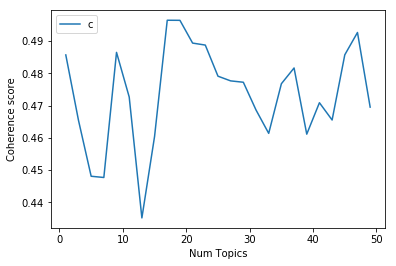

In [35]:
limit=50 
start=1 
step=2
x = range(start, limit, step)
print(x)
print(coherence_values)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [36]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.4857
Num Topics = 3  has Coherence Value of 0.4654
Num Topics = 5  has Coherence Value of 0.4481
Num Topics = 7  has Coherence Value of 0.4477
Num Topics = 9  has Coherence Value of 0.4865
Num Topics = 11  has Coherence Value of 0.4727
Num Topics = 13  has Coherence Value of 0.4352
Num Topics = 15  has Coherence Value of 0.4604
Num Topics = 17  has Coherence Value of 0.4964
Num Topics = 19  has Coherence Value of 0.4964
Num Topics = 21  has Coherence Value of 0.4894
Num Topics = 23  has Coherence Value of 0.4887
Num Topics = 25  has Coherence Value of 0.4791
Num Topics = 27  has Coherence Value of 0.4776
Num Topics = 29  has Coherence Value of 0.4772
Num Topics = 31  has Coherence Value of 0.4686
Num Topics = 33  has Coherence Value of 0.4614
Num Topics = 35  has Coherence Value of 0.4768
Num Topics = 37  has Coherence Value of 0.4816
Num Topics = 39  has Coherence Value of 0.4611
Num Topics = 41  has Coherence Value of 0.4709
Num Topics = 43  h

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. 
<https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda>

Now, the question arises which model should we pick now? One of the good practices is to pick the model, that is giving highest coherence value before flattering out. So that’s why, we will be choosing the model with 25 topics which is at number 4 in the above list.
<https://www.tutorialspoint.com/gensim/gensim_documents_and_lda_model.htm>

In [37]:
## Add the number in the list of the optimal topic number, then print out that number of topics. 
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.018*"obesity" + 0.017*"bmi" + 0.013*"weight" + 0.009*"overweight" + '
  '0.008*"activity" + 0.008*"student" + 0.007*"diabetes" + 0.007*"obese" + '
  '0.007*"child" + 0.006*"cholesterol"'),
 (1,
  '0.095*"hypertension" + 0.040*"psychological" + 0.030*"stress" + '
  '0.026*"distress" + 0.018*"sample" + 0.015*"al" + 0.015*"activity" + '
  '0.014*"control" + 0.012*"pakistani" + 0.012*"pakistan"'),
 (2,
  '0.020*"patient" + 0.011*"family" + 0.010*"anger" + 0.009*"depression" + '
  '0.008*"score" + 0.006*"show" + 0.006*"smoker" + 0.005*"income" + '
  '0.005*"psychiatric_morbidity" + 0.005*"work"')]


### Finding dominant topics in sentences

Finding dominant topics in sentences is one of the most useful practical applications of topic modeling. It determines what topic a given document is about. Here, we will find that topic number which has the highest percentage contribution in that particular document. In order to aggregate the information in a table, we will be creating a function named dominant_topics() 
<https://www.tutorialspoint.com/gensim/gensim_documents_and_lda_model.htm>

In [38]:
def format_topics_sentences(ldamodel=topic_model, corpus=bow_corpus, texts=texts_out_2):
    ## Init output
    sent_topics_df = pd.DataFrame()

    ## Next, we will get the main topics in every document −
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        ## Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=texts_out_2)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.5205,"patient, family, anger, depression, score, sho...","[prevalence, valvular, heart, disease, elderly..."
1,1,0.0,0.8100,"obesity, bmi, weight, overweight, activity, st...","[maintain, young, adult, weight, limit, risk, ..."
2,2,0.0,0.7957,"obesity, bmi, weight, overweight, activity, st...","[maintain, young, adult, weight, help, deter, ..."
3,3,0.0,0.8216,"obesity, bmi, weight, overweight, activity, st...","[stable, weight, avert, risk, factor, young, a..."
4,4,0.0,0.8164,"obesity, bmi, weight, overweight, activity, st...","[stable, weight, avert, risk, factor, young, a..."
5,5,0.0,0.8235,"obesity, bmi, weight, overweight, activity, st...","[stable, weight, avert, risk, factor, young, a..."
6,6,0.0,0.8142,"obesity, bmi, weight, overweight, activity, st...","[stable, weight, avert, risk, factor, young, a..."
7,7,2.0,0.5002,"patient, family, anger, depression, score, sho...","[high, prevalence, valvular, disease, find, el..."
8,8,0.0,0.7613,"obesity, bmi, weight, overweight, activity, st...","[understanding, obesity, understand, obesity, ..."
9,9,2.0,0.5084,"patient, family, anger, depression, score, sho...","[passive, smoking, raise, glucose_intolerance,..."


### Finding Most Representative Document
In order to understand more about the topic, we can also find the documents, a given topic has contributed to the most. We can infer that topic by reading that particular document(s).

In [39]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9486,"obesity, bmi, weight, overweight, activity, st...","[impact, overweight, obesity, ventilatory_func..."
1,1.0,0.9780,"hypertension, psychological, stress, distress,...","[psychological, stress, distress, anthropometr..."
2,2.0,0.9471,"patient, family, anger, depression, score, sho...","[psychiatric_morbidity, associate, socio_demog..."


### Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [40]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"patient, family, anger, depression, score, sho...",66.0,0.6226
1.0,0.0,"obesity, bmi, weight, overweight, activity, st...",9.0,0.0849
2.0,0.0,"obesity, bmi, weight, overweight, activity, st...",31.0,0.2925
3.0,0.0,"obesity, bmi, weight, overweight, activity, st...",NaN,NaN
4.0,0.0,"obesity, bmi, weight, overweight, activity, st...",NaN,NaN
...,...,...,...,...
101.0,0.0,"obesity, bmi, weight, overweight, activity, st...",NaN,NaN
102.0,0.0,"obesity, bmi, weight, overweight, activity, st...",NaN,NaN
103.0,0.0,"obesity, bmi, weight, overweight, activity, st...",NaN,NaN
104.0,2.0,"patient, family, anger, depression, score, sho...",NaN,NaN


### Volume & Distribution of Topics
Sometimes we also want to judge how widely the topic is discussed in documents. For this we need to understand the volume and distribution of topics across the documents.

First calculate the number of documents for every Topic as follows −

In [44]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
print(topic_counts)

0.0    66
2.0    31
1.0     9
Name: Dominant_Topic, dtype: int64


Next, calculate the percentage of Documents for every Topic as follows −;

In [45]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
print(topic_contribution)

0.0    0.6226
2.0    0.2925
1.0    0.0849
Name: Dominant_Topic, dtype: float64


Now find the topic Number and Keywords as follows −

In [46]:
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
print(topic_num_keywords)

     Dominant_Topic                                     Topic_Keywords
0               2.0  patient, family, anger, depression, score, sho...
1               0.0  obesity, bmi, weight, overweight, activity, st...
2               0.0  obesity, bmi, weight, overweight, activity, st...
3               0.0  obesity, bmi, weight, overweight, activity, st...
4               0.0  obesity, bmi, weight, overweight, activity, st...
..              ...                                                ...
101             0.0  obesity, bmi, weight, overweight, activity, st...
102             0.0  obesity, bmi, weight, overweight, activity, st...
103             0.0  obesity, bmi, weight, overweight, activity, st...
104             2.0  patient, family, anger, depression, score, sho...
105             2.0  patient, family, anger, depression, score, sho...

[106 rows x 2 columns]


Now, concatenate then Column wise as follows −

In [47]:
df_dominant_topics = pd.concat(
   [topic_num_keywords, topic_counts, topic_contribution], axis=1
)

Next, we will change the Column names as follows −

In [48]:
df_dominant_topics.columns = [
   'Dominant-Topic', 'Topic-Keywords', 'Num_Documents', 'Perc_Documents'
]
df_dominant_topics

,Dominant-Topic,Topic-Keywords,Num_Documents,Perc_Documents
0.0,2.0,"patient, family, anger, depression, score, sho...",66.0,0.6226
1.0,0.0,"obesity, bmi, weight, overweight, activity, st...",9.0,0.0849
2.0,0.0,"obesity, bmi, weight, overweight, activity, st...",31.0,0.2925
3.0,0.0,"obesity, bmi, weight, overweight, activity, st...",NaN,NaN
4.0,0.0,"obesity, bmi, weight, overweight, activity, st...",NaN,NaN
...,...,...,...,...
101.0,0.0,"obesity, bmi, weight, overweight, activity, st...",NaN,NaN
102.0,0.0,"obesity, bmi, weight, overweight, activity, st...",NaN,NaN
103.0,0.0,"obesity, bmi, weight, overweight, activity, st...",NaN,NaN
104.0,2.0,"patient, family, anger, depression, score, sho...",NaN,NaN


## Apply the Dynamic Topic Model 

Use the Dynamic Topic Model (DTM) wrapper to identify how topics change over time.  

Resources: 
* <https://markroxor.github.io/gensim/static/notebooks/dtm_example.html>
* <http://users.umiacs.umd.edu/~jbg/nips_tm_workshop/30.pdf>
* <https://radimrehurek.com/gensim/models/ldaseqmodel.html>


In [49]:
## Generate the LDASEQ model
## use the corpus from earlier
## use the dictonary from earlier
## use the time_slices from earlier
## use the optimal number of topics from earlier

ldaseq = ldaseqmodel.LdaSeqModel(corpus=bow_corpus, id2word=dictionary, time_slice=time_slices, num_topics=3)

## https://stackoverflow.com/questions/55490182/gensim-models-ldaseqmodel-py217-runtimewarning-divide-by-zero-encountered-in

C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [50]:
# Get topics of each slice from the result
topics = []
i = 0
while i < 14:
    topic_i = []
    for topic in ldaseq.print_topics(time=i, top_terms=20):
        topic_i.append(topic)
    topics.append(topic_i)
    i += 1

# Save topics to CSV
df_topics = pd.DataFrame(topics)
with open(r"Test_Files\DTM_timeslices.csv", 'w', newline="", encoding='utf-8') as file:
    df_topics.to_csv(file)


In [51]:
## Load csv as a dataframe

DTM_timeslices_df = pd.read_csv("Test_Files\DTM_timeslices.csv", index_col=0) 
DTM_timeslices_df.head()

<>:3: DeprecationWarning: invalid escape sequence \D
<>:3: DeprecationWarning: invalid escape sequence \D
<>:3: DeprecationWarning: invalid escape sequence \D
<ipython-input-51-8ba02c9a8ed4>:3: DeprecationWarning: invalid escape sequence \D
  DTM_timeslices_df = pd.read_csv("Test_Files\DTM_timeslices.csv", index_col=0)


,0,1,2
0,"[('weight', 0.025465142691823296), ('obesity',...","[('hypertension', 0.044738512594628264), ('pat...","[('bmi', 0.0313089344325822), ('obesity', 0.02..."
1,"[('weight', 0.019459611996995297), ('obesity',...","[('hypertension', 0.04487143104699833), ('pati...","[('bmi', 0.03219253759845819), ('obesity', 0.0..."
2,"[('weight', 0.015893125054497883), ('obesity',...","[('hypertension', 0.04803282394718758), ('pati...","[('bmi', 0.033326816717185855), ('obesity', 0...."
3,"[('weight', 0.013149599633825398), ('obesity',...","[('hypertension', 0.06331846475196334), ('pati...","[('bmi', 0.034449558035721216), ('obesity', 0...."
4,"[('weight', 0.011894640301383066), ('activity'...","[('hypertension', 0.08124174944193192), ('pati...","[('bmi', 0.0359809495074056), ('obesity', 0.02..."


In [79]:
print(DTM_timeslices_df.keys())
# DTM_timeslices_df.head()

# rename columns
DTM_timeslices_df.rename(columns = {'0':'Topic_0', '1': 'Topic_1', '2':'Topic_2' }, inplace = True) 

# iterating the columns 
for col in DTM_timeslices_df.columns: 
    print(col) 

DTM_timeslices_df.head()

Index(['Topic_0', 'Topic_1', 'Topic_2'], dtype='object')
Topic_0
Topic_1
Topic_2


,Topic_0,Topic_1,Topic_2
0,"[('weight', 0.025465142691823296), ('obesity',...","[('hypertension', 0.044738512594628264), ('pat...","[('bmi', 0.0313089344325822), ('obesity', 0.02..."
1,"[('weight', 0.019459611996995297), ('obesity',...","[('hypertension', 0.04487143104699833), ('pati...","[('bmi', 0.03219253759845819), ('obesity', 0.0..."
2,"[('weight', 0.015893125054497883), ('obesity',...","[('hypertension', 0.04803282394718758), ('pati...","[('bmi', 0.033326816717185855), ('obesity', 0...."
3,"[('weight', 0.013149599633825398), ('obesity',...","[('hypertension', 0.06331846475196334), ('pati...","[('bmi', 0.034449558035721216), ('obesity', 0...."
4,"[('weight', 0.011894640301383066), ('activity'...","[('hypertension', 0.08124174944193192), ('pati...","[('bmi', 0.0359809495074056), ('obesity', 0.02..."


In [80]:
## Create a function to convert the topic string (literally displayed as dict) to dictionary
def convert_toDict(topic):
    topic_i=[]
    for line in topic:
        sub={}
        line = ast.literal_eval (line)
        for tup in line:
            sub[tup[0]]=tup[1]
        topic_i.append(sub)
    return topic_i

## Create a function to get terms and their probabilities from all topics
def get_term_prob (term, topic):
    term_list=[]
    for item in topic:
        #print("This is item:", item)
        #print("This is item keys:", item.keys())
        if term in item.keys():
            #print("This is term:", term)
            for k, v in item.items():
                if k ==term:
                    term_list.append(v)
        else:
            term_list.append(0)
    return term_list


<>:264: DeprecationWarning: invalid escape sequence \D
<>:264: DeprecationWarning: invalid escape sequence \D
<>:264: DeprecationWarning: invalid escape sequence \D
<ipython-input-83-a7174db169e3>:264: DeprecationWarning: invalid escape sequence \D
  fig.savefig("Test_Files\DTM_timeslices.png")


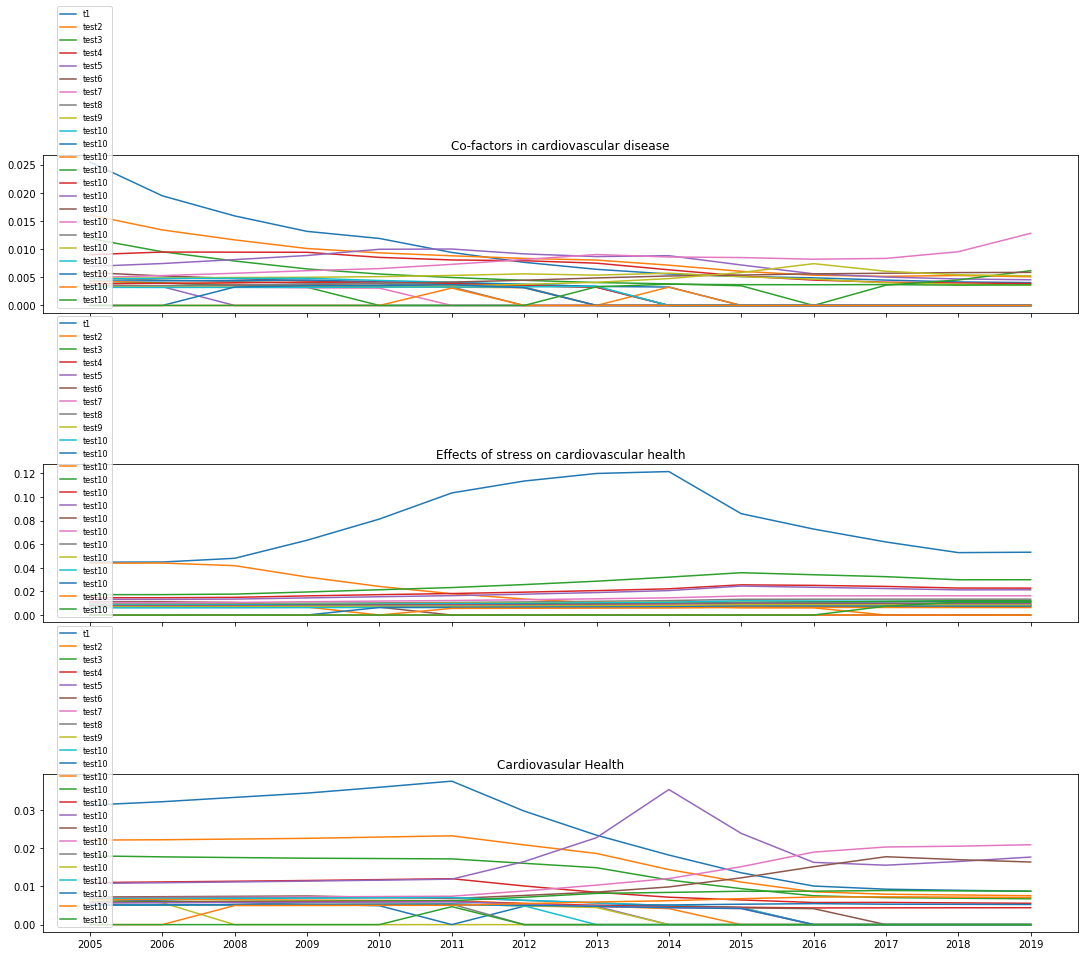

In [83]:
# Extract terms and term probabilities from the topics to save separately

# Topic 0
topic_0 = convert_toDict(DTM_timeslices_df['Topic_0'])
weight_0 = get_term_prob("weight",topic_0)
obesity_0 = get_term_prob("obesity",topic_0)
bmi_0 = get_term_prob("bmi",topic_0)
diabetes_0 = get_term_prob("diabetes",topic_0)
activity_0 = get_term_prob("activity",topic_0)
kg_0 = get_term_prob("kg",topic_0)
patient_0 = get_term_prob("patient",topic_0)
gain_0 = get_term_prob("gain",topic_0)
cholesterol_0 = get_term_prob("cholesterol",topic_0)
develop_0 = get_term_prob("develop",topic_0)
type_0 = get_term_prob("type",topic_0)
triglyceride_0 = get_term_prob("triglyceride",topic_0)
smoker_0= get_term_prob("smoker",topic_0)
metabolic_syndrome_0 = get_term_prob("metabolic_syndrome",topic_0)
prevalence_0 = get_term_prob("prevalence",topic_0)
al_0 = get_term_prob("al",topic_0)
blood_pressure_0 = get_term_prob("blood_pressure",topic_0)
diet_0 = get_term_prob("diet",topic_0)
child_0= get_term_prob("child",topic_0)
exercise_0 = get_term_prob("exercise",topic_0)
uric_acid_0 = get_term_prob("uric_acid",topic_0)
serum_uric_acid_0 = get_term_prob("serum_uric_acid",topic_0)
gender_0 = get_term_prob("gender",topic_0)
show_0 = get_term_prob("show",topic_0)
effect_0 = get_term_prob("effect",topic_0)
value_0 = get_term_prob("value",topic_0)
case_0 = get_term_prob("case",topic_0)
use_0 = get_term_prob("use",topic_0)
test_0 = get_term_prob("test",topic_0)
score_0 = get_term_prob("score",topic_0)
normal_0 = get_term_prob("normal",topic_0)
student_0 = get_term_prob("student",topic_0)

# Topic 1
topic_1 = convert_toDict(DTM_timeslices_df['Topic_1'])
hypertension_1 = get_term_prob("hypertension",topic_1)
patient_1 = get_term_prob("patient",topic_1)
psychological_1 = get_term_prob("psychological",topic_1)
stress_1 = get_term_prob("stress",topic_1)
distress_1 = get_term_prob("distress",topic_1)
pci_1 = get_term_prob("pci",topic_1)
sample_1 = get_term_prob("sample",topic_1)
al_1 = get_term_prob("al",topic_1)
control_1 = get_term_prob("control",topic_1)
activity_1= get_term_prob("activity",topic_1)
non_1 = get_term_prob("non", topic_1)
coronary_1 = get_term_prob("coronary", topic_1)
case_1 = get_term_prob("case", topic_1)
blood_pressure_1 = get_term_prob("blood_pressure", topic_1)
pakistani_1 = get_term_prob("pakistani", topic_1)
pakistan_1= get_term_prob("pakistan", topic_1)
history_1 = get_term_prob("history", topic_1)
family_1 = get_term_prob("family", topic_1)
smoking_1 = get_term_prob("smoking", topic_1)
gender_1 = get_term_prob("gender", topic_1)
obesity_1 = get_term_prob("obesity", topic_1)
anthropometric_lifestyle_correlates_1= get_term_prob("anthropometric_lifestyle_correlates", topic_1)
reward_1 = get_term_prob("reward", topic_1)




# Topic 2
topic_2 = convert_toDict(DTM_timeslices_df['Topic_2'])
bmi_2 = get_term_prob("bmi", topic_2)
obesity_2= get_term_prob("obesity", topic_2)
overweight_2= get_term_prob("overweight", topic_2)
student_2= get_term_prob("student", topic_2)
anger_2= get_term_prob("anger", topic_2)
depression_2= get_term_prob("depression", topic_2)
family_2= get_term_prob("family", topic_2)
obese_2= get_term_prob("obese", topic_2)
valvular_2= get_term_prob("valvular", topic_2)
weight_2= get_term_prob("weight", topic_2)
prevalence_2= get_term_prob("prevalence", topic_2)
pulmonary_function_2= get_term_prob("pulmonary_function", topic_2)
pakistan_2= get_term_prob("pakistan", topic_2)
impact_2= get_term_prob("impact", topic_2)
fev_fvc_2= get_term_prob("fev_fvc", topic_2)
test_2= get_term_prob("test", topic_2)
male_2= get_term_prob("male", topic_2)
fev_fvc_ratio_2= get_term_prob("fev_fvc_ratio", topic_2)
fvc_2= get_term_prob("fvc", topic_2)
fev_2= get_term_prob("fev", topic_2)
male_2= get_term_prob("male", topic_2)
show_2= get_term_prob("show", topic_2)
mass_index_2= get_term_prob("mass_index", topic_2)
stress_2= get_term_prob("stress", topic_2)
socio_demographic_2= get_term_prob("socio_demographic", topic_2)
anxiety_2= get_term_prob("anxiety", topic_2)
psychiatric_morbidity_2= get_term_prob("psychiatric_morbidity", topic_2)
agression_2= get_term_prob("agression", topic_2)
correlate_2= get_term_prob("correlate", topic_2)
income_2= get_term_prob("income", topic_2)
mental_2= get_term_prob("mental", topic_2)
non_2= get_term_prob("non", topic_2)
diabetes_2 = get_term_prob("diabetes",topic_2)
pci_2 = get_term_prob("pci",topic_2)
stroke_2 = get_term_prob("stroke",topic_2)
coronary_2 = get_term_prob("coronary",topic_2)
obesity_2 = get_term_prob("obesity",topic_2)
pakistan_2 = get_term_prob("pakistan",topic_2)
stent_2 = get_term_prob("stent",topic_2)
depression_2 = get_term_prob("depression",topic_2)
cabg_2 = get_term_prob("cabg",topic_2)


# Plot the topic evolution graph
# Create subplots
fig, (plt1,plt2, plt3) = plt.subplots(3,1,figsize=(15, 13), sharex=True, constrained_layout=True)

# Create a function to plot lines within subplots
def plot_line (t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23, plt, str_label):
    x=np.array(["2005", "2006", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"])
    plt.plot(x, t1, label = convert_VarTostr(t1))
    plt.plot(x, t2, label = 'test2')
    plt.plot(x, t3, label = 'test3')
    plt.plot(x, t4, label = 'test4')
    plt.plot(x, t5, label = 'test5')
    plt.plot(x, t6, label = 'test6')
    plt.plot(x, t7, label = 'test7')
    plt.plot(x, t8, label = 'test8')
    plt.plot(x, t9, label = 'test9')
    plt.plot(x, t10,label = 'test10')
    plt.plot(x, t11,label = 'test10')
    plt.plot(x, t12,label = 'test10')
    plt.plot(x, t13,label = 'test10')
    plt.plot(x, t14,label = 'test10')
    plt.plot(x, t15,label = 'test10')
    plt.plot(x, t16,label = 'test10')
    plt.plot(x, t17,label = 'test10')
    plt.plot(x, t18,label = 'test10')
    plt.plot(x, t19,label = 'test10')
    plt.plot(x, t20,label = 'test10')
    plt.plot(x, t21,label = 'test10')
    plt.plot(x, t22,label = 'test10')
    plt.plot(x, t23,label = 'test10')
    plt.set_title(str_label)
    plt.legend(loc='lower left', bbox_to_anchor=(0.01, 0.005), fontsize=8)
#     print("This is t1:", t1)
 
    return plt

def convert_VarTostr(var):
    #print("This is var: ", var)
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    #print("This is callers:", callers_local_vars)
    f= [var_name for var_name, var_val in callers_local_vars if var_val is var]
    #print("this is f:", f)
    #print("this is var_name: ", var_name)
    #print("this is var_val: ", var_val)
    return f[0]

## Resources
## https://stackoverflow.com/questions/55760681/how-to-get-the-list-name-passed-as-a-parameter-to-a-function-in-python

# Plot subgraphs by using created functions

plt1=plot_line(weight_0,
               obesity_0,
               bmi_0,
               diabetes_0,
               activity_0,
               kg_0,
               patient_0,
               gain_0,
               cholesterol_0,
               develop_0,
               type_0, 
               triglyceride_0,
               smoker_0, 
               metabolic_syndrome_0, 
               prevalence_0, 
               al_0, 
               blood_pressure_0, 
               diet_0, 
               child_0, 
               exercise_0, 
               uric_acid_0, 
               serum_uric_acid_0,
               gender_0,
               #show_0,
               #effect_0,
               #value_0,
               #case_0,
               #use_0,
               #test_0,
               #score_0,
               #normal_0,
               #student_0,
               plt1, 
               'Co-factors in cardiovascular disease')


plt2=plot_line(hypertension_1,
               patient_1, 
               psychological_1,
               stress_1,
               distress_1,
               pci_1, 
               sample_1,
               al_1,
               control_1,
               activity_1,
               non_1, 
               coronary_1, 
               case_1, 
               blood_pressure_1, 
               pakistani_1, 
               pakistan_1, 
               history_1, 
               family_1, 
               smoking_1, 
               gender_1, 
               obesity_1,
               anthropometric_lifestyle_correlates_1,
               reward_1,
               plt2, 
               'Effects of stress on cardiovascular health')


plt3=plot_line(bmi_2,
                obesity_2,
                overweight_2,
                student_2,
                anger_2,
                depression_2,
                family_2,
                obese_2,
                valvular_2,
                weight_2,
                prevalence_2,
                pulmonary_function_2,
                pakistan_2,
                impact_2,
                fev_fvc_2,
                test_2,
                male_2,
                fev_fvc_ratio_2,
                fvc_2,
                fev_2,
                male_2,
                show_2,
                mass_index_2,
                #stress_2,
                #socio_demographic_2,
                #anxiety_2,
                #psychiatric_morbidity_2,
                #agression_2,
                #correlate_2,
                #income_2,
                #mental_2,
                #non_2,
                plt3, 
               'Cardiovasular Health')


                                                           
# Save the graph
fig.savefig("Test_Files\DTM_timeslices.png")


## Resources
## https://www.geeksforgeeks.org/python-convert-list-of-tuples-to-list-of-list/
## https://www.geeksforgeeks.org/python-concatenate-values-with-same-keys-in-a-list-of-dictionaries/

In [ ]:
## Run the Gensim Library TFIDF Model 
##The words that will occur more frequently in the document will get the smaller weights.
##https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py
##new_list = []

# tfidf_frequency = []

# def run_gensim_tfidf_model(corpus, dictionary): 
    
#     ##Initialize the tf-idf model, training it on our corpus 
#     tfidf = models.TfidfModel(corpus)
    
#     ##if working with a new document, you can get tfidf from the model
#     #new_doc = "abbott bra adolesc".lower().split()
#     #print(new_doc)
#     #new_list.append(tfidf[dictionary.doc2bow(new_doc)])
    
#     corpus_tfidf = tfidf[corpus]
#     for doc in corpus_tfidf:
#         ##pprint.pprint(doc)
#         tfidf_frequency.append(doc)
    
#     #Print word frequencies by vector 
#     id_words_frequency = [[(dictionary[id], frequency) for id, frequency in line] for line in tfidf_frequency]
#     print("Word Frequency by Vector: ")
#     pprint.pprint(id_words_frequency[2])
    
# run_gensim_tfidf_model(bow_corpus, dictionary)

#pprint.pprint(tfidf_frequency)
    